In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
torch.cuda.empty_cache()

In [3]:
# 파일이 저장된 디렉토리 경로
test_code_directory = 'C:\\big18\\final\\with\\almost\\test_data'
model_directory = 'C:\\big18\\final\\with\\almost\\gcn_model'

In [4]:
# 파일명에서 특정 부분 추출
test_codes = []
for filename in os.listdir(test_code_directory):
    if filename.endswith('체결강도Vector.csv'):
        test_codes.append(filename[:len('체결강도Vector.csv') * -1]) # 뒷 부분 제거

model_names = []
for filename in os.listdir(model_directory):
    if filename.endswith('.pth'):
        model_names.append(filename.split('.')[0])

In [5]:
test_codes

['000105', '000660_2', '000660_3', '000660_4', '001755', '214270', '288330']

In [6]:
for code in test_codes:
    result_acc_map = {}
    print(f'GPU available : {torch.cuda.is_available()}')
    for model_name in model_names:
        # 데이터 로드
        df = pd.read_csv(f'C:\\big18\\final\\with\\almost\\test_data\\{code}체결강도Vector.csv')
        # df = df.iloc[:,2:]
        # df = df.astype('float16')

        print(df)
        # 노드 특징 행렬 (Node feature matrix)
        x = torch.tensor(df.iloc[:,:-1].values, dtype=torch.float)

        # 엣지 리스트 (Edge list)
        edge_index = []
        num_rows = len(df)
        for i in range(num_rows - 1):
            edge_index.append([i, i + 1])
            edge_index.append([i + 1, i])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        # 레이블
        y = torch.tensor(df['18'].values, dtype=torch.long)

        train_data = Data(x=x, edge_index=edge_index, y=y)

        #      복잡 모델
        class GCN(torch.nn.Module):
            def __init__(self, num_node_features, num_classes):
                super(GCN, self).__init__()
                self.conv1 = GCNConv(num_node_features, 16)
                self.bn1 = BatchNorm1d(16)
                self.conv2 = GCNConv(16, 32)
                self.bn2 = BatchNorm1d(32)
                self.conv3 = GCNConv(32, 64)
                self.bn3 = BatchNorm1d(64)
                self.conv4 = GCNConv(64, num_classes)
                # self.bn4 = BatchNorm1d(128)
                # self.conv5 = GCNConv(128, num_classes)
                # self.bn5 = BatchNorm1d(256)
                # self.conv6 = GCNConv(256, num_classes)
                # self.bn6 = BatchNorm1d(512)
                # self.conv7 = GCNConv(512, num_classes)
                self.dropout = torch.nn.Dropout(p=0.5)

            def forward(self, data):
                x, edge_index = data.x, data.edge_index

                x = self.conv1(x, edge_index)
                x = self.bn1(x)
                x = F.gelu(x)
                # x = self.dropout(x)

                x = self.conv2(x, edge_index)
                x = self.bn2(x)
                x = F.gelu(x)
                # x = self.dropout(x)

                x = self.conv3(x, edge_index)
                x = self.bn3(x)
                x = F.gelu(x)
                x = self.dropout(x)
                
                x = self.conv4(x, edge_index)
                # x = self.bn4(x)
                # x = F.gelu(x)
                # x = self.dropout(x)
                
                # x = self.conv5(x, edge_index)
                # x = self.bn5(x)
                # x = F.gelu(x)
                # x = self.dropout(x)
                
                # x = self.conv6(x, edge_index)
                # x = self.bn6(x)
                # x = F.gelu(x)
                # x = self.dropout(x)
                
                # x = self.conv7(x, edge_index)

                return F.log_softmax(x, dim=1)

        # 모델 초기화
        model = GCN(num_node_features=x.size(1), num_classes=len(y.unique()))

        # 장치 설정
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        train_data = train_data.to(device)

        # 옵티마이저 정의
        optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)  #   optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)  # 학습률&정규화 조정 (model.parameters(), lr=0.01, weight_decay=5e-4)
        scheduler = StepLR(optimizer, step_size=1000, gamma=0.9)

        # 정확도 계산 함수
        def accuracy(pred, labels):
            _, pred_classes = pred.max(dim=1)
            correct = (pred_classes == labels).sum().item()
            return correct / len(labels)

        # 학습 완료 후 최종 평가
        model.load_state_dict(torch.load(f'C:\\big18\\final\\with\\almost\\gcn_model\\{model_name}.pth'))
        model.eval()
        with torch.no_grad():
            final_out = model(train_data)
            final_loss = F.nll_loss(final_out, train_data.y)
            final_acc = accuracy(final_out, train_data.y)
            # val_out = model(train_data)
            val_pred = final_out.max(dim=1)[1].cpu().numpy()
            val_true = train_data.y.cpu().numpy()

        conf_matrix = confusion_matrix(val_true, val_pred)
        class_report = classification_report(val_true, val_pred)

        print("Confusion Matrix:")
        print(conf_matrix)

        print("\nClassification Report:")
        print(class_report)
        print(f'Final Eval Loss: {final_loss.item():.4f}, Final Eval Accuracy: {final_acc:.4f}')
        
        result_acc_map[model_name.split('_')[-1]] = {'conf_matrix':conf_matrix, 'cloass_report':class_report, 'final_acc':final_acc}

        real_close_data = pd.read_csv(f'C:\\big18\\final\\with\\almost\\test_data\\{code}.csv',encoding='cp949')
        real_close_data = real_close_data['종가']

        val_pred = val_pred.astype(float)
        val_pred = np.insert(val_pred, 0, [np.nan] * 12)

        df = pd.DataFrame({
            '종가': real_close_data,
            '예측 행동': val_pred
        })
        # 결과 데이터프레임 출력
        print(df)

        # results_df.to_excel('C:/big18/dl-dev/dl-dev/project/변동률과 체결강도/000660_2급등주행동예측.xlsx')

        # 백테스팅
        # 초기 자본금
        initial_capital = 200000
        capital = initial_capital
        position = 0  # 현재 보유 주식 수
        buy_price = 0  # 매수 가격
        sell_count = 0  # 총 매도 횟수
        buy_count = 0  # 총 매수 횟수
        sell_fee = 0.00195
        buy_fee = 0.00015

        fee = 0 # 수수료

        # 결과를 저장할 리스트
        results = []

        # 수익률 계산
        for i in range(len(df)):
            if df['예측 행동'][i] == 2 and position == 0:  # 매수 조건
                position = capital // df['종가'][i-2]  # 최대 매수 가능 수량
                buy_price = df['종가'][i-2]  # 매수 가격
                buy_count += 1  # 매수 횟수
                fee += (buy_price * position) * buy_fee  # 매수 수수료
                capital -= (position * buy_price) + ((buy_price * position) * buy_fee)  # 자본금 감소
                results.append({'행동': '매수', '가격': buy_price, '잔고': capital})

            elif df['예측 행동'][i] == 0 and position > 0:  # 매도 조건
                sell_price = df['종가'][i-2]  # 매도 가격
                capital += (position * sell_price) - ((sell_price * position) * sell_fee)  # 매도 후 자본금 증가
                fee += (sell_price * position) * sell_fee  # 매도 수수료
                sell_count += 1  # 매도 횟수
                
                # 수익률 계산
                profit_per_share = sell_price - buy_price
                profit_rate = profit_per_share - buy_price
                
                results.append({'행동': '매도', '가격': sell_price, '잔고': capital, '수익금': profit_per_share})
                position = 0  # 보유 주식 수 초기화

        # 결과를 데이터프레임으로 변환
        results_df = pd.DataFrame(results)
        # results_df.to_excel('./하이닉스수익확인.xlsx')
        # 최종 자산 가치 계산
        final_value = capital + position * df['종가'].iloc[-1]
        profit = final_value - initial_capital
        profit_rate = (profit / initial_capital) * 100

        print(f'초기 자본금: {initial_capital}원')
        print(f'최종 자산 가치: {final_value:.2f}원')
        print(f'총 수익: {profit:.2f}원')
        print(f'수익률: {profit_rate:.2f}%')
        print(f'매도 횟수: {sell_count}, 매수 횟수: {buy_count}')
        print(f'총 수수료 : {fee:.2f}원')

        # 결과 출력
        results_df
        
    with open (f'C:\\big18\\final\\with\\almost\\result_acc_map\\result_acc_map_{code}.pkl', 'wb') as file:
        pickle.dump(result_acc_map, file)


GPU available : True
            0         1         2         3         4         5         6  \
0   -136.3636   38.4369 -205.7878   -6.3012  -25.1889 -282.6633  152.7184   
1     38.4369 -205.7878   -6.3012  -25.1889 -282.6633  152.7184 -428.0397   
2   -205.7878   -6.3012  -25.1889 -282.6633  152.7184 -428.0397 -356.9304   
3     -6.3012  -25.1889 -282.6633  152.7184 -428.0397 -356.9304  155.0833   
4    -25.1889 -282.6633  152.7184 -428.0397 -356.9304  155.0833  122.5204   
..        ...       ...       ...       ...       ...       ...       ...   
362  -53.8793  -32.1543   10.6838  -37.4332   31.9659  -32.0684  -95.8977   
363  -32.1543   10.6838  -37.4332   31.9659  -32.0684  -95.8977   10.5541   
364   10.6838  -37.4332   31.9659  -32.0684  -95.8977   10.5541   68.6741   
365  -37.4332   31.9659  -32.0684  -95.8977   10.5541   68.6741    5.3191   
366   31.9659  -32.0684  -95.8977   10.5541   68.6741    5.3191   -5.3220   

            7         8        9       10       11    

In [7]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 다른 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호 깨짐 방지

all_accuracy = []

for code in test_codes:
    with open(f'C:\\big18\\final\\with\\almost\\result_acc_map\\result_acc_map_{code}.pkl', 'rb') as file:
        pickle_load = pickle.load(file)

    model_list = [i for i in pickle_load.keys()]
    model_list.sort()
    accuracy_list = [pickle_load[i]['final_acc'] for i in model_list]
    all_accuracy.append(accuracy_list)

In [8]:
average_accuracy = [sum(i) / len(i) for i in zip(*all_accuracy)]

In [9]:
average_accuracy

[0.8398792761866977,
 0.8664033538642709,
 0.8294098807201626,
 0.8443855751516909,
 0.8218320802747651,
 0.8306054709342081,
 0.8600400462834384,
 0.8759728853759026,
 0.7812544793742882,
 0.856535205066376,
 0.7448393051498241,
 0.8592967933510028,
 0.8200865041504409,
 0.8339974438547549,
 0.838317787590522,
 0.8305103970291247,
 0.7788535728400368,
 0.6630189790919795,
 0.7974688215338549,
 0.8502294267374536,
 0.8075173560500344,
 0.8300494437207971,
 0.8001581193247912,
 0.8049674529708294]

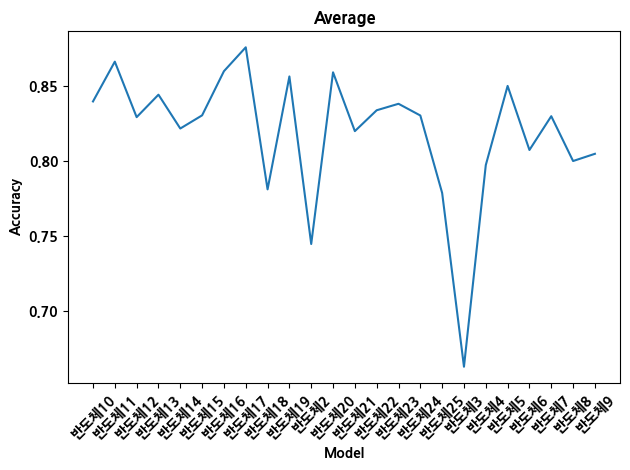

In [11]:
plt.plot(model_list, average_accuracy)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Average')
plt.xticks(rotation=45)
# plt.ylim(0, 1)
plt.tight_layout()  # 레이아웃 조정)
plt.show()